If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses the keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [7]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.layers import Conv2D
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Define the game environment and replay classes

In [8]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1:] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim[0], env_dim[1], env_dim[2]))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




## Creating Snake Enviorment

In [20]:
class Snake(object):
    def __init__(self, grid_size = 45, max_moves_multiplyer = 1):
        self.max_moves = (grid_size**2) *  max_moves_multiplyer
        self.grid_size = grid_size
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]
    
    def _update_state(self, action):
        [fruit_x, fruit_y], snake, [move] = self.state
        
        direction = [snake[0][0] - snake[1][0], snake[0][1] - snake[1][1]]
        if action == 0:
            movement = direction # Forward
        elif action == 1:
            movement = [-1*direction[1], direction[0]] # Right
        elif action == 2:
            movement = [direction[1], -1*direction[0]] # Down
        else:
            raise Exception('Invalid action {}'.format(action))
        
        snake_new = [np.add(snake[0], movement).tolist()] + snake
        
        if [fruit_x, fruit_y] not in snake_new:
            snake_new = snake_new[:-1]
        
        #print("Snake: {}".format(snake))
        self.state = [[fruit_x, fruit_y], snake_new, [move + 1]]
        
    def _draw_state(self):
        
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        [fruit_x, fruit_y], snake, [move] = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[snake[0][1]][snake[0][0]] = .75
        for coord in snake[1:]:
            try:
                canvas[coord[1]][coord[0]] = .5  # draw snake
            except IndexError:
                canvas = np.zeros(im_size)
                print("index error")
                break
        return canvas
        
    def _get_reward(self):
        
        [fruit_x, fruit_y], snake, [move] = self.state
        if snake[0] in snake[1:]:
            #print("ouch")
            return -1 # it hit itself
        if snake[0][0] < 0 or snake[0][0] > self.grid_size - 1 or snake[0][1] < 0 or snake[0][1] > self.grid_size - 1:
            return -1 # it hit a wall
        if [fruit_x, fruit_y] in snake:
            #print("got fruit?")
            while [fruit_x, fruit_y] in snake: # reseting fruit probably, need a better way if the snake gets good.
                fruit_x = np.random.randint(0, grid_size)
                fruit_y = np.random.randint(0, grid_size)
            self.state[0] = [fruit_x, fruit_y]
            self.state[2] = [0]
            return 1 # it ate the fruit
        if move > (self.max_moves) + (len(snake)):
            return -1 # ran out of time
#         if (fruit_x - snake[0][0])**2 + (fruit_y - snake[0][1])**2 < (fruit_x - snake[1][0])**2 + (fruit_y - snake[1][1])**2:
#             return 1
        else:
            return 0 # the fruit is still on the board
    
    def observe(self):
        
        canvas = self._draw_state()
        
        return np.array([np.expand_dims(canvas, axis = 2)])
    
    def act(self, action):
        
        self._update_state(action)
        reward = self._get_reward()
        if reward != -1:
            observation = self.observe()
        else:
            [fruit_x, fruit_y], snake, [move] = self.state
            self.state = [[fruit_x, fruit_y], snake[1:], [move]] # removing head bc if it goes out of bounds then the observe does not work.
            observation = self.observe()
        
        game_over = (reward < 0) # if the reward is -1 then the snake died
        return observation, reward, game_over
    
    def reset(self):
        
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]

##  Functions for creating, training, and visualizing the model

In [21]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, move_forward, move_right]
max_memory = 500
hidden_size = 32
batch_size = 50
grid_size = 10
discount = .99

def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Conv2D(filters = hidden_size, kernel_size = 3, input_shape = (grid_size, grid_size, 1), activation='relu'))
    model.add(Conv2D(filters = hidden_size, kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = hidden_size, kernel_size = 3, activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2, clipnorm = 1.0), "mse")

    # Define environment/game
    env = Snake(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory, discount = discount)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    totals = []
    for episode in range(num_episodes):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()
        
        catch_count = 0

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)
            if reward == 1:
                catch_count += 1

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            # get data updated based on the stored experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on the updated data
            loss += model.train_on_batch(inputs, targets)

            starting_observation = new_observation # for next time through the loop
        
        totals.append(catch_count)
        totals = totals[max(len(totals)-10, 0):]
        avg = round(sum(totals)/len(totals), 2)

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Catch count {} | Average {}".format(episode, num_episodes-1, loss, catch_count, avg))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    
    observations = []
    for _ in range(num_games):
        print("game start")
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
#             action = np.random.randint(0,4)
#             action = 1
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            #print("move")
            print(reward)
        print("game end")
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [22]:
model, env, exp_replay = build_model()

game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


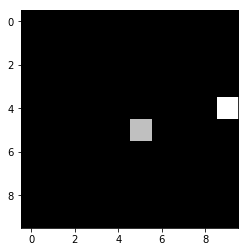

In [23]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episode 0000/0999 | Loss 0.0151 | Catch count 0 | Average 0.0
Episode 0001/0999 | Loss 0.3064 | Catch count 0 | Average 0.0
Episode 0002/0999 | Loss 0.2497 | Catch count 0 | Average 0.0
Episode 0003/0999 | Loss 0.1223 | Catch count 0 | Average 0.0
Episode 0004/0999 | Loss 0.0819 | Catch count 0 | Average 0.0
Episode 0005/0999 | Loss 0.4990 | Catch count 0 | Average 0.0
Episode 0006/0999 | Loss 0.2835 | Catch count 1 | Average 0.14
Episode 0007/0999 | Loss 0.5079 | Catch count 0 | Average 0.12
Episode 0008/0999 | Loss 0.1763 | Catch count 1 | Average 0.22
Episode 0009/0999 | Loss 0.5401 | Catch count 0 | Average 0.2
Episode 0010/0999 | Loss 0.0905 | Catch count 0 | Average 0.2
Episode 0011/0999 | Loss 0.0334 | Catch count 0 | Average 0.2
Episode 0012/0999 | Loss 0.5140 | Catch count 1 | Average 0.3
Episode 0013/0999 | Loss 0.2871 | Catch count 0 | Average 0.3
Episode 0014/0999 | Loss 0.5074 | Catch count 0 | Average 0.3
Episode 0015/0999 | Loss 0.6750 | Catch count 1 | Average 0.4
Episo

Episode 0132/0999 | Loss 0.0857 | Catch count 0 | Average 0.0
Episode 0133/0999 | Loss 0.0715 | Catch count 0 | Average 0.0
Episode 0134/0999 | Loss 0.0594 | Catch count 0 | Average 0.0
Episode 0135/0999 | Loss 0.1779 | Catch count 1 | Average 0.1
Episode 0136/0999 | Loss 0.2185 | Catch count 0 | Average 0.1
Episode 0137/0999 | Loss 0.7311 | Catch count 2 | Average 0.3
Episode 0138/0999 | Loss 0.0763 | Catch count 1 | Average 0.4
Episode 0139/0999 | Loss 0.5267 | Catch count 1 | Average 0.5
Episode 0140/0999 | Loss 4.9211 | Catch count 1 | Average 0.6
Episode 0141/0999 | Loss 11.7774 | Catch count 0 | Average 0.6
Episode 0142/0999 | Loss 44.7034 | Catch count 0 | Average 0.6
Episode 0143/0999 | Loss 235.0000 | Catch count 0 | Average 0.6
Episode 0144/0999 | Loss 14.8044 | Catch count 0 | Average 0.6
Episode 0145/0999 | Loss 11.6840 | Catch count 1 | Average 0.6
Episode 0146/0999 | Loss 19.5303 | Catch count 0 | Average 0.6
Episode 0147/0999 | Loss 210.6849 | Catch count 0 | Average 0.4

Episode 0260/0999 | Loss 8958.0737 | Catch count 0 | Average 0.4
Episode 0261/0999 | Loss 23305.3573 | Catch count 0 | Average 0.4
Episode 0262/0999 | Loss 18034.9896 | Catch count 0 | Average 0.3
Episode 0263/0999 | Loss 72090.2282 | Catch count 0 | Average 0.3
Episode 0264/0999 | Loss 34595.2478 | Catch count 0 | Average 0.3
Episode 0265/0999 | Loss 33302.2046 | Catch count 0 | Average 0.2
Episode 0266/0999 | Loss 52734.4666 | Catch count 1 | Average 0.3
Episode 0267/0999 | Loss 79946.0398 | Catch count 1 | Average 0.2
Episode 0268/0999 | Loss 30295.2077 | Catch count 0 | Average 0.2
Episode 0269/0999 | Loss 139795.3626 | Catch count 0 | Average 0.2
Episode 0270/0999 | Loss 19120.0861 | Catch count 0 | Average 0.2
Episode 0271/0999 | Loss 207393.5136 | Catch count 0 | Average 0.2
Episode 0272/0999 | Loss 121181.7750 | Catch count 0 | Average 0.2
Episode 0273/0999 | Loss 7557.0378 | Catch count 1 | Average 0.3
Episode 0274/0999 | Loss 29964.8958 | Catch count 0 | Average 0.3
Episode 0

Episode 0383/0999 | Loss 148382.8054 | Catch count 0 | Average 0.2
Episode 0384/0999 | Loss 228590.5897 | Catch count 0 | Average 0.2
Episode 0385/0999 | Loss 160559.7463 | Catch count 0 | Average 0.2
Episode 0386/0999 | Loss 338132.1559 | Catch count 0 | Average 0.2
Episode 0387/0999 | Loss 61165.4265 | Catch count 0 | Average 0.2
Episode 0388/0999 | Loss 301640.6545 | Catch count 0 | Average 0.2
Episode 0389/0999 | Loss 180672.7965 | Catch count 0 | Average 0.2
Episode 0390/0999 | Loss 141176.9452 | Catch count 0 | Average 0.0
Episode 0391/0999 | Loss 7583.8839 | Catch count 1 | Average 0.1
Episode 0392/0999 | Loss 62770.6291 | Catch count 0 | Average 0.1
Episode 0393/0999 | Loss 102228.6740 | Catch count 0 | Average 0.1
Episode 0394/0999 | Loss 53374.0347 | Catch count 0 | Average 0.1
Episode 0395/0999 | Loss 45385.4307 | Catch count 0 | Average 0.1
Episode 0396/0999 | Loss 50348.6148 | Catch count 0 | Average 0.1
Episode 0397/0999 | Loss 59110.2968 | Catch count 0 | Average 0.1
Epi

Episode 0506/0999 | Loss 780890.2290 | Catch count 0 | Average 0.1
Episode 0507/0999 | Loss 1553766.7041 | Catch count 0 | Average 0.1
Episode 0508/0999 | Loss 415061.0146 | Catch count 0 | Average 0.0
Episode 0509/0999 | Loss 1594176.6479 | Catch count 0 | Average 0.0
Episode 0510/0999 | Loss 728792.1309 | Catch count 0 | Average 0.0
Episode 0511/0999 | Loss 563522.5713 | Catch count 0 | Average 0.0
Episode 0512/0999 | Loss 2346485.4961 | Catch count 0 | Average 0.0
Episode 0513/0999 | Loss 1638602.7173 | Catch count 0 | Average 0.0
Episode 0514/0999 | Loss 809922.3301 | Catch count 0 | Average 0.0
Episode 0515/0999 | Loss 1162377.5154 | Catch count 0 | Average 0.0
Episode 0516/0999 | Loss 178764.8740 | Catch count 0 | Average 0.0
Episode 0517/0999 | Loss 1329134.5027 | Catch count 0 | Average 0.0
Episode 0518/0999 | Loss 1265289.7236 | Catch count 0 | Average 0.0
Episode 0519/0999 | Loss 178018.1816 | Catch count 0 | Average 0.0
Episode 0520/0999 | Loss 1281844.0854 | Catch count 0 |

Episode 0628/0999 | Loss 2657165.4590 | Catch count 1 | Average 0.2
Episode 0629/0999 | Loss 1479998.7100 | Catch count 0 | Average 0.2
Episode 0630/0999 | Loss 314949.8193 | Catch count 1 | Average 0.3
Episode 0631/0999 | Loss 2400919.6074 | Catch count 0 | Average 0.3
Episode 0632/0999 | Loss 2508974.1401 | Catch count 0 | Average 0.3
Episode 0633/0999 | Loss 1562922.1460 | Catch count 2 | Average 0.5
Episode 0634/0999 | Loss 282464.1597 | Catch count 0 | Average 0.5
Episode 0635/0999 | Loss 399581.5439 | Catch count 0 | Average 0.4
Episode 0636/0999 | Loss 449778.8643 | Catch count 0 | Average 0.4
Episode 0637/0999 | Loss 98669.6387 | Catch count 0 | Average 0.4
Episode 0638/0999 | Loss 972391.8301 | Catch count 0 | Average 0.3
Episode 0639/0999 | Loss 334038.4546 | Catch count 0 | Average 0.3
Episode 0640/0999 | Loss 730827.6182 | Catch count 0 | Average 0.2
Episode 0641/0999 | Loss 2350414.2773 | Catch count 0 | Average 0.2
Episode 0642/0999 | Loss 2839948.5864 | Catch count 0 | A

Episode 0749/0999 | Loss 17248345.8203 | Catch count 0 | Average 0.4
Episode 0750/0999 | Loss 4145729.7500 | Catch count 1 | Average 0.5
Episode 0751/0999 | Loss 9420364.0000 | Catch count 0 | Average 0.5
Episode 0752/0999 | Loss 8237775.0898 | Catch count 0 | Average 0.5
Episode 0753/0999 | Loss 9768412.2852 | Catch count 1 | Average 0.6
Episode 0754/0999 | Loss 19138232.3242 | Catch count 0 | Average 0.6
Episode 0755/0999 | Loss 1626285.6992 | Catch count 0 | Average 0.4
Episode 0756/0999 | Loss 5382183.1738 | Catch count 2 | Average 0.6
Episode 0757/0999 | Loss 1876804.1426 | Catch count 0 | Average 0.4
Episode 0758/0999 | Loss 3264750.3340 | Catch count 0 | Average 0.4
Episode 0759/0999 | Loss 3652565.0684 | Catch count 0 | Average 0.4
Episode 0760/0999 | Loss 4808400.0020 | Catch count 0 | Average 0.3
Episode 0761/0999 | Loss 1382382.0000 | Catch count 0 | Average 0.3
Episode 0762/0999 | Loss 2122702.6113 | Catch count 0 | Average 0.3
Episode 0763/0999 | Loss 4072126.3672 | Catch 

Episode 0870/0999 | Loss 258807.4961 | Catch count 0 | Average 0.1
Episode 0871/0999 | Loss 1016287.6699 | Catch count 1 | Average 0.2
Episode 0872/0999 | Loss 3567491.1582 | Catch count 0 | Average 0.2
Episode 0873/0999 | Loss 4750786.4873 | Catch count 0 | Average 0.2
Episode 0874/0999 | Loss 4531489.1875 | Catch count 0 | Average 0.1
Episode 0875/0999 | Loss 4946897.5742 | Catch count 0 | Average 0.1
Episode 0876/0999 | Loss 2328334.5723 | Catch count 0 | Average 0.1
Episode 0877/0999 | Loss 1907744.0449 | Catch count 0 | Average 0.1
Episode 0878/0999 | Loss 6212229.8789 | Catch count 0 | Average 0.1
Episode 0879/0999 | Loss 2938612.0977 | Catch count 0 | Average 0.1
Episode 0880/0999 | Loss 5086274.9668 | Catch count 1 | Average 0.2
Episode 0881/0999 | Loss 3091972.7021 | Catch count 0 | Average 0.1
Episode 0882/0999 | Loss 1782496.0342 | Catch count 0 | Average 0.1
Episode 0883/0999 | Loss 139170.9370 | Catch count 0 | Average 0.1
Episode 0884/0999 | Loss 1511734.0732 | Catch coun

Episode 0991/0999 | Loss 243920.4707 | Catch count 0 | Average 0.0
Episode 0992/0999 | Loss 1382401.5879 | Catch count 0 | Average 0.0
Episode 0993/0999 | Loss 4519153.4355 | Catch count 1 | Average 0.1
Episode 0994/0999 | Loss 1057029.2441 | Catch count 0 | Average 0.1
Episode 0995/0999 | Loss 5924378.6973 | Catch count 1 | Average 0.2
Episode 0996/0999 | Loss 991824.5684 | Catch count 0 | Average 0.2
Episode 0997/0999 | Loss 3024486.1436 | Catch count 0 | Average 0.2
Episode 0998/0999 | Loss 4801406.3809 | Catch count 0 | Average 0.2
Episode 0999/0999 | Loss 4554456.0820 | Catch count 0 | Average 0.2
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


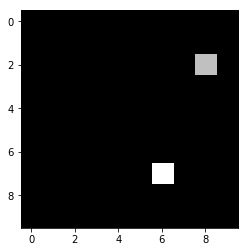

In [24]:
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works, using more of a policy gradient strategy.

In [4]:
a = [1,2,3]
a[1:]

[2, 3]

In [50]:
np.expand_dims([[1,2],[3,4]], axis = 2)

array([[[1],
        [2]],

       [[3],
        [4]]])